### Imports

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn
import os
import glob

import pandas as pd

### Functions

In [2]:
def find_nearest(array,value):
    idx,val = min(enumerate(array), key=lambda x: abs(x[1]-value))
    return idx

### Define paths and read data

In [3]:
# Paths and ensemble members
EXP="HIST2"
OP="/work/scratch-pw3/atb299/"+EXP+"/"
ENS=sorted(os.listdir(OP))

In [4]:
# List of lists of files
EM_moc_files=[]
EM_mocsig_files=[]
for i in ENS:
    EM_moc_files.append(glob.glob(OP+i+"/OCN/yearly/*/*_moc.nc"))
    EM_mocsig_files.append(glob.glob(OP+i+"/OCN/yearly/*/*_mocsig.nc"))

In [5]:
# Read data into an xarray dataset with new dimension 'ensemble_member'
EM_moc = xr.open_mfdataset(EM_moc_files[0])
EM_moc['ensemble_member'] = int(ENS[0])
EM_moc = EM_moc.expand_dims(dim='ensemble_member').set_coords('ensemble_member')

for i in range(1,len(ENS)):
    ds = xr.open_mfdataset(EM_moc_files[i])
    ds['ensemble_member'] = int(ENS[i])
    ds = ds.expand_dims(dim='ensemble_member').set_coords('ensemble_member')
    EM_moc = xr.concat([EM_moc,ds],'ensemble_member')

In [6]:
EM_moc['depthw'] = EM_moc['depthw']*-1 # Depth should be positive down!

### EM_moc is now a single dataset which looks like this...

In [7]:
EM_moc

<xarray.Dataset>
Dimensions:          (depthw: 75, time_counter: 780, ensemble_member: 20,
                      y: 1207, x: 1)
Coordinates:
  * depthw           (depthw) float32 0.0 1.024 2.103 ... 5.596e+03 5.8e+03
  * time_counter     (time_counter) object 1950-01-16 00:00:00 ... 2014-12-16...
  * ensemble_member  (ensemble_member) int64 1 10 11 12 13 18 2 ... 31 4 5 6 7 9
Dimensions without coordinates: y, x
Data variables: (12/26)
    nav_lon          (ensemble_member, time_counter, y, x) float32 dask.array<chunksize=(1, 12, 1207, 1), meta=np.ndarray>
    nav_lat          (ensemble_member, time_counter, y, x) float32 dask.array<chunksize=(1, 12, 1207, 1), meta=np.ndarray>
    zomsfglo         (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
    zomsfglo_sh      (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
    zomsfglo_bt      (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
    zomsfglo_ag      (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
    ...               ...
    zomsfpac_bt      (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
    zomsfpac_ag      (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
    zomsfinp0        (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
    zomsfinp0_sh     (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
    zomsfinp0_bt     (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
    zomsfinp0_ag     (ensemble_member, time_counter, depthw, y, x) float32 dask.array<chunksize=(1, 12, 75, 1207, 1), meta=np.ndarray>
Attributes:
    start_date:        -1
    output_frequency:  N/A
    CONFIG:            N/A
    CASE:              N/A
    history:           Tue Mar  5 08:41:26 2024: ncks -O --no_abc --4 --dfl_l...
    NCO:               netCDF Operators version 5.1.5 (Homepage = http://nco....

In [8]:
# Size of dataset in GB
EM_moc.nbytes/1024**3

126.39991967007518

### Find 26N and 1km, extract AMOC@26N

In [10]:
y26 = find_nearest(EM_moc['nav_lat'][0,0,:,0],26)
y42 = find_nearest(EM_moc['nav_lat'][0,0,:,0],42)
y50 = find_nearest(EM_moc['nav_lat'][0,0,:,0],50)
z1k = find_nearest(EM_moc['depthw'],1000)
EM_amoc_26N = EM_moc['zomsfatl'].isel(y=y26).compute()
EM_amoc_42N = EM_moc['zomsfatl'].isel(y=y42).compute()
EM_amoc_50N = EM_moc['zomsfatl'].isel(y=y50).compute()

EM_amoc_26N_1k = EM_amoc_26N.isel(depthw=z1k)

### Write extracted AMOC variables - small files for ease of use

In [11]:
EM_amoc_26N.to_netcdf(OP+"Ensemble_amoc_z_26N.nc")
EM_amoc_42N.to_netcdf(OP+"Ensemble_amoc_z_42N.nc")
EM_amoc_50N.to_netcdf(OP+"Ensemble_amoc_z_50N.nc")

### Plot AMOC time series

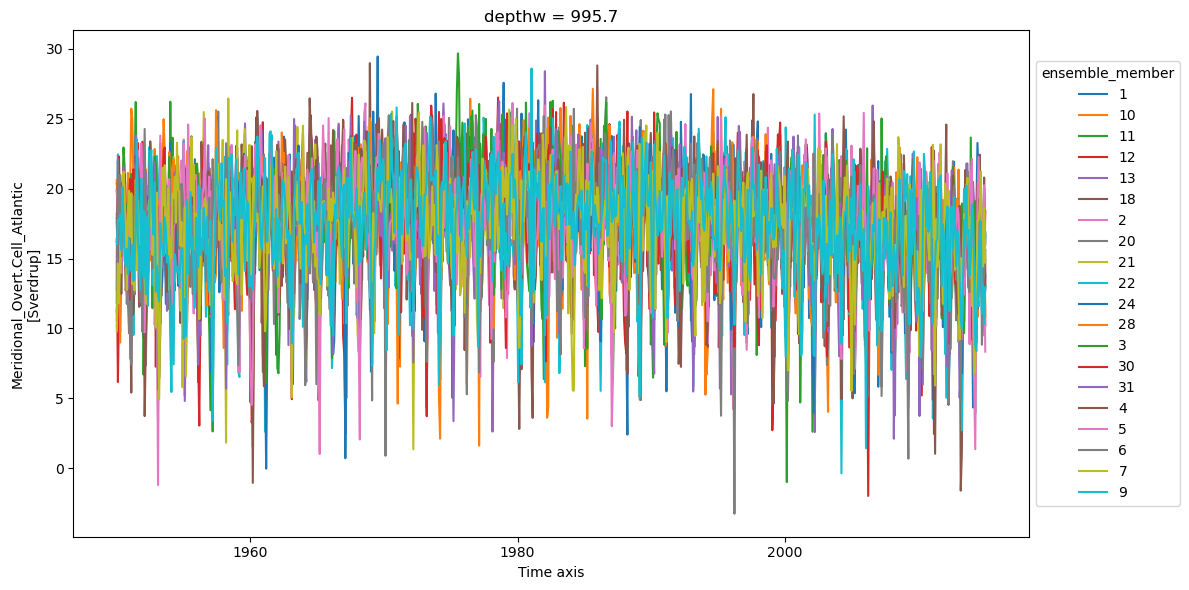

In [12]:
EM_amoc_26N_1k[:,:,0].plot.line(hue='ensemble_member',size=6,aspect=2);
seaborn.move_legend(plt.gca(), loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()

In [13]:
EM_amoc_26N_1k = EM_amoc_26N_1k.to_dataset()

In [14]:
EM_amoc_26N_1k['zomsfatl_mean'] = EM_amoc_26N_1k['zomsfatl'].mean(dim='ensemble_member')
EM_amoc_26N_1k['zomsfatl_var'] = EM_amoc_26N_1k['zomsfatl'].var(dim='ensemble_member')


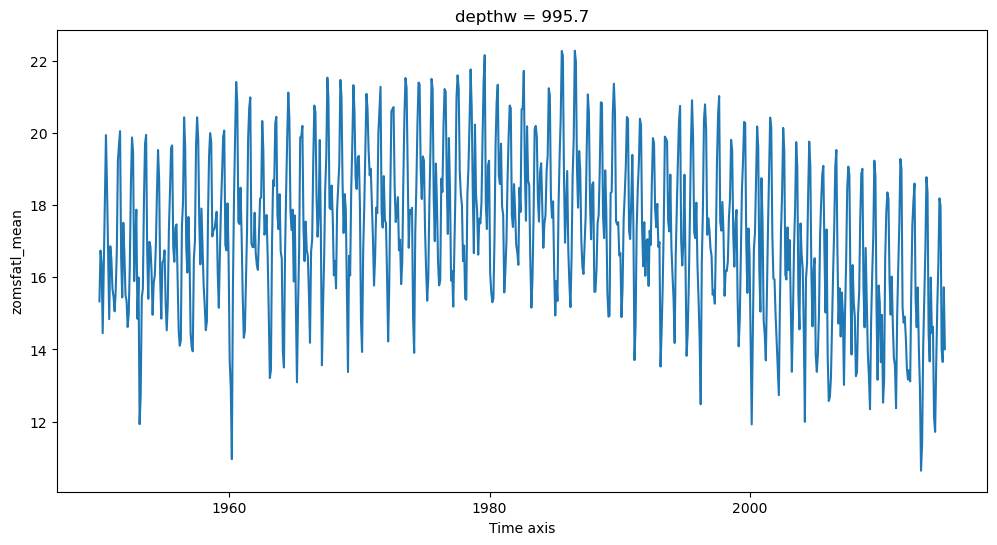

In [15]:
EM_amoc_26N_1k['zomsfatl_mean'].plot(size=6,aspect=2)